In [1]:
import pandas as pd
import joblib
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import eval
from helpers.preprocessing import read_all_data
from mlp_architecture import MLPDataset, MLPModel
import yaml
from torch.utils.data import DataLoader
from helpers import TrainingLoop

In [2]:

# y = pd.read_csv('test_data/subject_009_01__y.csv')

In [3]:
device = torch.device('cpu')

# Load initial model
with open('../c2_final_models/initial_hyperparams.yaml') as f:
    initial_hyperparams = yaml.load(f, Loader=yaml.SafeLoader)
initial_model = eval.load_model('../c2_final_models/initial2.torch', MLPModel(initial_hyperparams))

# Load tuned model
# with open('../c2_final_models/tuned_hyperparams.yaml') as f:
#     tuned_hyperparams = yaml.load(f, Loader=yaml.SafeLoader)
# tuned_model = eval.load_model('../c2_final_models/tuned_mlp_model.torch', MLPModel(tuned_hyperparams))

In [5]:
import os
if os.getcwd().split('/')[-1] == 'MLP':
    os.chdir('..')

data_dict = read_all_data()
imu = data_dict['imu'].to_numpy()
ann = data_dict['ann'].to_numpy().flatten()
del data_dict # Remove to free memory

initial_tl = TrainingLoop(MLPModel, MLPDataset, initial_hyperparams, imu, ann, device, 'initial2')
# tuned_tl = TrainingLoop(MLPModel, MLPDataset, tuned_hyperparams, imu, ann, device)

Using device: cpu


100%|██████████| 525/525 [00:03<00:00, 170.67it/s]
/home/jacob/ece542_repos/c1_collaboration/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


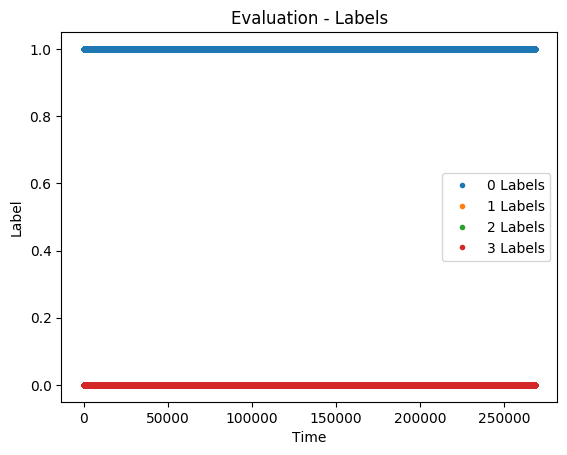

[[1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,

In [7]:
eval.evaluate(initial_model, initial_tl.val_generator, plot=True)
# eval.evaluate(tuned_model, tuned_tl.val_generator, plot=True)

In [8]:
from torch import nn
import torchmetrics as tm

def model_output_to_classes(model_output:torch.Tensor) -> torch.Tensor:
    return torch.max(model_output, 1)[1] # Indices of max values

def stats(model:nn.Module, dataloader:torch.utils.data.DataLoader, num_classes) -> float:
    
    precision = tm.Precision(task="multiclass", average='macro', num_classes=num_classes)
    recall = tm.Recall(task="multiclass", average='macro', num_classes=num_classes)
    f_one = tm.F1Score(task="multiclass", num_classes=num_classes)

    precisions = []
    recalls = []
    f_ones = []
    f_ones1 = []
    f_ones2 = []
    f_ones3 = []
    f_ones4 = []
    for (X, y) in tqdm(dataloader):
        model.eval()
        with torch.no_grad():
            y_p = model_output_to_classes(model(X))
            recalls.append((recall(y_p,y)).item())
            precisions.append((precision(y_p,y)).item())
            f_ones.append((f_one(y_p,y)).item())
            oney = y.clone()
            oneyp = y_p.clone()
            oney[oney!=0] = -1
            oneyp[oneyp!=0] = -1

            twoy = y.clone()
            twoyp = y_p.clone()
            twoy[twoy!=1] = -1
            twoyp[twoyp!=1] = -1

            threey = y.clone()
            threeyp = y_p.clone()
            threey[threey!=2] = -1
            threeyp[threeyp!=2] = -1

            foury = y.clone()
            fouryp = y_p.clone()
            foury[foury!=3] = -1
            fouryp[fouryp!=3] = -1

            f_ones1.append((f_one(oneyp,oney)).item())
            f_ones2.append((f_one(twoyp,twoy)).item())
            f_ones3.append((f_one(threeyp,threey)).item())
            f_ones4.append((f_one(fouryp,foury)).item())
    return sum(precisions)/len(precisions), sum(recalls)/len(recalls), sum(f_ones)/len(f_ones), sum(f_ones1)/len(f_ones1),sum(f_ones2)/len(f_ones2),sum(f_ones3)/len(f_ones3),sum(f_ones4)/len(f_ones4)

initial_stats = stats(initial_model, initial_tl.val_generator, num_classes=initial_hyperparams['num_classes'])
# tuned_stats = stats(tuned_model, tuned_tl.val_generator, num_classes=tuned_hyperparams['num_classes'])
print(initial_stats)
# print(tuned_stats)

100%|██████████| 525/525 [00:04<00:00, 113.98it/s]

(0.18773371066365924, 0.25, 0.750934842654637)


In [13]:
from helpers.preprocessing import normalize_data

def read_test_data(path):
    arr = pd.read_csv(path, names=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']).to_numpy()
    return normalize_data(arr, method='standard')[0]
    

In [14]:
import os
if os.getcwd().split('/')[-1] == 'MLP':
    os.chdir('..')
    
x = read_test_data('test_data/subject_009_01__x.csv')

In [15]:
x

array([[-0.03765202,  0.09368573, -1.7321851 , -0.00663184,  0.02365164,
        -0.09008276],
       [-0.03524099,  0.09306726, -1.728587  , -0.00705779,  0.0281753 ,
        -0.08657224],
       [-0.03380179,  0.09325268, -1.7369238 , -0.00627698,  0.03112727,
        -0.08585816],
       ...,
       [ 0.03822476,  0.15150486, -1.60053846, -0.00630514,  0.0324014 ,
        -0.09299229],
       [ 0.0431868 ,  0.15453199, -1.60594713, -0.00646107,  0.03021339,
        -0.09217475],
       [ 0.04604466,  0.1530275 , -1.60284796, -0.00726302,  0.02892234,
        -0.09488228]])

In [16]:
scaler = joblib.load('c2_final_models/initial2_scaler.joblib')
scaled_x = scaler.transform(x)
scaled_x

array([[-0.0370895 ,  0.09315268, -1.73292282, -0.00625479,  0.02383534,
        -0.0897086 ],
       [-0.03467921,  0.09253409, -1.72932459, -0.00668064,  0.02835584,
        -0.08619918],
       [-0.03324047,  0.09271955, -1.73766171, -0.00590001,  0.03130575,
        -0.08548532],
       ...,
       [ 0.03876358,  0.15098284, -1.60127117, -0.00592817,  0.03257899,
        -0.09261722],
       [ 0.04372407,  0.15401055, -1.60668004, -0.00608405,  0.03039251,
        -0.09179994],
       [ 0.04658104,  0.15250577, -1.60358076, -0.00688583,  0.02910236,
        -0.09450663]])

In [18]:
ytest_p = initial_model(torch.tensor(x, dtype=torch.float32))
out = TrainingLoop.model_output_to_classes(ytest_p)
print(out)

tensor(0)


In [26]:
y_t = pd.read_csv('test_data/subject_009_01__y_time.csv', names=['time'])
x_t = pd.read_csv('test_data/subject_009_01__x_time.csv', names=['time'])

In [27]:
import numpy as np
def nearest_neighbors_downsample(y_time, x_time):
    out = []
    for y_t in y_time:
        diff = np.absolute(x_time - y_t)
        index = diff.argmin()
        out.append(ann[index])
    return out

y = nearest_neighbors_downsample(y_t.to_numpy().flatten(), x_t.to_numpy().flatten())

In [36]:
np.savetxt('predictions/subject_009_01__y.csv', y, delimiter=',')
